# Kristijono Donelaičio 'Metų' hegzametras

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")

def write_table(df, the_name):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write(df.style.to_latex(hrules=True))

In [2]:
all_caesuras = ["3h", "5h", "ktt", "7h", "pqt", "bd"]
df = pd.read_csv("metai/metai-scansion.csv")
print(len(df))

2968


In [3]:
incorrect_lines = df[df.isnull()["scansion"]]
df = df.dropna()
print(len(incorrect_lines))

5


In [4]:
ambiguous = df["scansion"].str.contains(r'\|')
ambiguous_lines = df[ambiguous]
df = df[~ambiguous]
print(len(ambiguous_lines))

11


In [5]:
# convert data types
df["scansion"] = pd.Categorical(df["scansion"], sorted(df["scansion"].drop_duplicates().values, key=lambda x: x[::-1]))

for caesura in all_caesuras:
    df[caesura] = df[caesura].map({"True": True, "False": False})

for column in ["stressConflict", "metreConflict", "weightConflict", "syllables", "words"]:
    df[column] = df[column].astype(int)

In [6]:
len(df)

2952

## How well does the analysis match the syllables?

In [7]:
conflicts = df[["metreConflict", "stressConflict", "weightConflict"]].apply(pd.Series.value_counts)
write_table(conflicts, "conflics")
conflicts

,metreConflict,stressConflict,weightConflict
0,2920.0,2219.0,853
1,32.0,668.0,1084
2,NaN,56.0,701
3,NaN,9.0,239
4,NaN,NaN,60
5,NaN,NaN,14
6,NaN,NaN,1


In [8]:
# df["weightConflict"].astype(int).value_counts()
df[(df["weightConflict"] > 3) | (df["stressConflict"] > 2)][["book", "verse", "text"]]

,book,verse,text
53,1,54,ogĭ trŏbà vissà vissùr iškrypŭsĭ ròdės;
57,1,58,o găspădinnė jo pûstynes mandăgey̆ lópė.
133,1,134,"tù nè lúbiji pyragû neigĭ răgaišiû,"
193,1,194,àr sù próvita pučkà tikt mùšă tĭkt mùša-
231,1,232,bèt dâr tai nĕ gănà; jis viss pĭnnį̆gu ...
...,...,...,...
2687,4,402,"tù, tărė̆ prìčkus jám, saugókis kàspăr..."
2770,4,485,dievs ant sósto prakilnaùs tav pàliĕpė̆ s...
2820,4,535,ìr mus álų sù gvoltù jau vìsą̆ sŭgėrę
2885,4,600,àliĕ sŭ vienă dienà žiedélis dár nĕsĭ...


## Amount of syllables

In [9]:
# syll / words
syls_per_words = (df.groupby("book")["syllables"].sum() / df.groupby("book")["words"].sum()).rename("Silben / Wort")
average_sylls = df.groupby("book")["syllables"].mean().rename("μ Silben")
stddev_sylls = df.groupby("book")["syllables"].std().rename("σ Silben")
df_syllables = pd.concat([syls_per_words, average_sylls, stddev_sylls], axis=1)
df_syllables.index = df_syllables.index.rename("Buch")
write_table(df_syllables, "syllables")
df_syllables

,Silben / Wort,μ Silben,σ Silben
Buch,,,
1,1.965188,13.551988,0.688711
2,1.973749,13.487288,0.652366
3,2.025509,13.452145,0.609369
4,1.982945,13.487518,0.646420


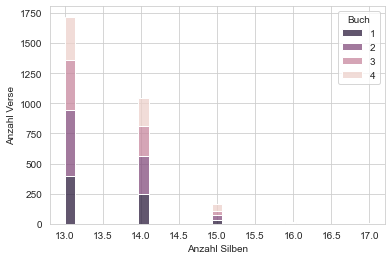

In [10]:
# syllable count histogram
ax = sns.histplot(x="syllables", data=df, hue="book", multiple="stack")
ax.set(xlabel='Anzahl Silben', ylabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
plt.savefig("figure-syllable-count-histogram.svg")

## Scansion

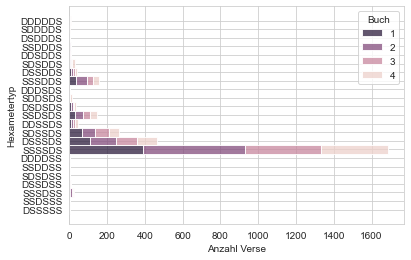

In [11]:
ax = sns.histplot(y="scansion", data=df, hue="book", multiple="stack")
ax.set(ylabel='Hexametertyp', xlabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
plt.savefig("figure-scansion-histogram.svg")

In [12]:
df_scansion = pd.DataFrame(df["scansion"].value_counts())
df_scansion["percent"] = 100 * df_scansion["scansion"] / len(df)
write_table(df_scansion, "scansion-types")
df_scansion[0:10]

,scansion,percent
SSSSDS,1689,57.215447
DSSSDS,464,15.718157
SDSSDS,263,8.909214
SSSDDS,157,5.318428
SSDSDS,144,4.878049
DDSSDS,47,1.592141
DSSDDS,39,1.321138
DSDSDS,33,1.117886
SDSDDS,27,0.914634
SSSDSS,26,0.880759


In [13]:
pd.crosstab(df['scansion'].rename("Hexametertyp"), df['syllables'].rename("Silbenzahl"))

Silbenzahl,13,14,15,16,17
Hexametertyp,,,,,
DDDDDS,0,0,0,0,6
SDDDDS,0,0,0,1,0
DSDDDS,0,0,0,5,0
SSDDDS,0,0,10,0,0
DDSDDS,0,0,0,7,0
SDSDDS,0,0,27,0,0
DSSDDS,0,0,39,0,0
SSSDDS,0,157,0,0,0
DDDSDS,0,0,0,1,0


In [14]:
strange_verses = df[df["scansion"].str.endswith("SSS")][["book", "verse", "text", "scansion"]]
write_table(strange_verses, "strange-verses")
strange_verses

,book,verse,text,scansion
1087,2,428,"iómarke brangvyno stuopą vìssą nŭrijęs,",DSSSSS
1118,2,459,"ik paskiáus iš pápykio beržinnį păgávęs,",SSDSSS
1693,3,320,"àr nĕsĭbìjotės užsprìngt, kad kábĭăr ...",DSSSSS
2418,4,133,ìr kitiems baudžáuninkams tikt gėdą pădáro.,SSDSSS


## Caesurae

### Caesuras per book

In [15]:
caesura_rows = []
for index, row in df.iterrows():
    for caesura in all_caesuras:
        if row[caesura] == True:
            caesura_rows.append([row["book"], row["verse"], caesura])
caesura_df = pd.DataFrame(caesura_rows, columns=["book", "verse", "caesura"])
caesura_df["caesura"] = pd.Categorical(caesura_df["caesura"], all_caesuras)

In [16]:
caesura_per_book = pd.crosstab(caesura_df["book"].rename("Buch"), caesura_df["caesura"].rename("Zäsur"))
write_table(caesura_per_book, "caesura-per-book")
caesura_per_book

Zäsur,3h,5h,ktt,7h,pqt,bd
Buch,,,,,,
1,380,492,11,394,10,387
2,395,548,8,430,11,392
3,525,703,6,549,9,514
4,372,530,4,430,10,372


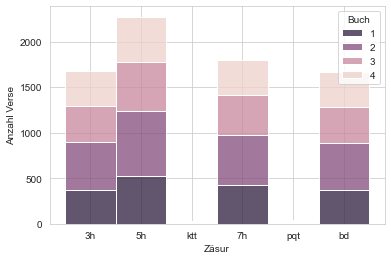

In [17]:
ax = sns.histplot(x="caesura", data=caesura_df, hue="book", multiple="stack")
ax.set(xlabel='Zäsur', ylabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
plt.savefig("figure-caesura-histogram.svg")

In [36]:
reslut = []
for s in all_caesuras:
    count = df[s].value_counts()[True]
    reslut.append([count, 100 * count / len(df)])
caesura_count = pd.DataFrame(reslut, columns=["Anzahl Verse", "Anteil/\\%"])
caesura_count.index = all_caesuras
caesura_count = caesura_count.sort_values("Anzahl Verse", ascending=False)
write_table(caesura_count, "caesura-count")
caesura_count


TypeError: to_latex() got an unexpected keyword argument 'decimal'

### Caesura-less lines

In [19]:
caesuraless = df[~df["3h"] & ~df["5h"] & ~df["ktt"] & ~df["7h"] & ~df["pqt"] & ~df["bd"]]
write_table(caesuraless, "caesuraless")
caesuraless

,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
1009,2,350,"taip, kàd klápai vyžu viežlibay pădărytû,",6,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,×––⏑×××××⏑⏑⏑–,1,––––⏑⏑–⏑–⏑⏑⏑–,2
1307,2,648,irgĭ kănápės vėjû parblôkštos svĭrĭne...,5,14,DSSSDS,False,False,False,False,False,False,×⏑⏑×××××××⏑⏑××,0,××⏑–⏑⏑–⏑–⏑××××,3,–⏑⏑–––––––⏑⏑–⏑,0
1485,3,112,"ir į sávŏ nămélį viezlibaý sŭvădìnęs,",6,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,××–⏑⏑–⏑⏑⏑–⏑⏑–⏑,1,–––⏑⏑–––⏑–⏑⏑⏑–,1
1538,3,165,"bèt, kaip pónai dáro, tranšieruot nĕmŏkė...",6,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,–×–⏑–⏑×××××××,0,–––––⏑–––⏑⏑––,0
2087,3,714,"bártis, ìrgĭ nĕšvánkey kóliotis ŭssĭma...",5,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,–⏑–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,–––⏑⏑––––––⏑––,1
2161,3,788,"ìr puikióku kùrpiu gėdėjos pămĭnėti,",5,13,SSSSDS,False,False,False,False,False,False,×××××××××⏑⏑××,0,–⏑–⏑–⏑×××××××,0,–––⏑–––––⏑⏑–⏑,0
2602,4,317,bèt ir dùrăką̆ pùloks pérplyšdams păgă...,6,14,SDSSDS,False,False,False,False,False,False,×××⏑⏑×××××⏑⏑××,0,–×–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,––⏑⏑–⏑––⏑–⏑⏑⏑⏑,4


### Caesura co-occurrences

In [20]:
from itertools import product
caesura_count = len(all_caesuras)
occurrences = np.zeros((caesura_count+1, caesura_count+1))
matrix = np.zeros((caesura_count))
for idx, row in df[all_caesuras].iterrows():
    for c1 in all_caesuras:
        if row[c1] and not any(row[c2] for c2 in all_caesuras if c2 != c1):
            i = all_caesuras.index(c1)
            matrix[i] += 1
    for c1, c2 in product(all_caesuras, all_caesuras):
        if c1 == c2:
            continue
        i1, i2 = all_caesuras.index(c1), all_caesuras.index(c2)
        if row[c1] and row[c2]:
            occurrences[i1, i2] += 1
occurrences[-1,:-1] = matrix
occurrences[:-1,-1] = matrix
occurrences = occurrences.astype(int)
df_occ = pd.DataFrame(occurrences, index=all_caesuras + ["∅"], columns=all_caesuras + ["∅"])

In [21]:
write_table(df_occ, "cooccurrences")
df_occ

,3h,5h,ktt,7h,pqt,bd,∅
3h,0,1199,10,987,22,978,19
5h,1199,0,6,1216,19,1419,56
ktt,10,6,0,17,0,16,1
7h,987,1216,17,0,14,667,116
pqt,22,19,0,14,0,0,5
bd,978,1419,16,667,0,0,6
∅,19,56,1,116,5,6,0


In [22]:
pd.DataFrame(df.groupby(all_caesuras).size().sort_values(ascending=False), columns=["Anzahl Verse"])

Anzahl Verse
3h    5h    ktt   7h    pqt   bd                 
True  True  False False False True            573
False True  False True  False False           388
                  False False True            377
True  True  False True  False False           347
      False False True  False False           260
False True  False True  False True            241
True  True  False True  False True            225
      False False True  False True            143
False False False True  False False           116
      True  False False False False            56
      False False True  False True             52
True  True  False False False False            41
      False False False False True             32
                              False            19
                        True  False            12
False False False False False False             7
            True  False False True              7
      True  False True  True  False             6
      False True  True  False False             6
            False False False True              6
      True  False False True  False             5
      False False False True  False             5
True  True  False False True  False             4
False False True  True  False True              4
True  True  False True  True  False             4
      False True  True  False False             2
      True  True  True  False False             2
False False False True  True  False             2
True  True  True  True  False True              2
      False True  False False True              2
            False True  True  False             2
False False True  False False False             1
True  False True  False False False             1
      True  True  False False True              1
False True  True  True  False False             1